In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
from geopandas.datasets import naturalearth_cities, naturalearth_lowres
import pycountry
import pycountry_convert as pc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Activation, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


In [189]:
world_geo = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [190]:
world_geo.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


In [191]:
world_geo.rename(columns={'name':'country'}, inplace=True)

In [192]:
world_geo['country'] = world_geo['country'].str.replace(' ','')

In [193]:
marry_dict

{'Bahamas': 'Bahamas,The',
 'BosniaandHerz.': 'BosniaandHerzegovina',
 'CentralAfricanRep.': 'CentralAfricanRepublic',
 "Côted'Ivoire": "Coted'Ivoire",
 'Dem.Rep.Congo': 'Congo(Brazzaville)',
 'Congo': 'Congo(Kinshasa)',
 'CzechRep.': 'Czechia',
 'DominicanRep.': 'DominicanRepublic',
 'Gambia': 'Gambia,The',
 'Eq.Guinea': 'EquatorialGuinea',
 'Korea': 'Korea,South',
 'LaoPDR': 'Laos',
 'Myanmar': 'Burma',
 'Dem.Rep.Korea': 'Korea,North',
 'W.Sahara': 'WesternSahara',
 'S.Sudan': 'SouthSudan',
 'SolomonIs.': 'SolomonIslands',
 'Swaziland': 'Eswatini'}

In [194]:
country_list = [i for i in marry_dict.keys()]

In [195]:
world_geo[world_geo['country'].isin(country_list)].index

Int64Index([17, 18, 26, 31, 33, 34, 40, 44, 61, 63, 87, 90, 105, 129, 137, 140,
            142, 152],
           dtype='int64')

In [196]:
world_geo['country'].iloc[[17, 18, 26, 31,
                           33, 34, 40, 44, 
                           61, 63, 87, 90, 
                           105, 129, 137, 
                           140,142, 152]
                         ]= world_geo[world_geo['country'].isin(country_list)]['country'].map(marry_dict)


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [197]:
world09 = pd.read_csv('../demographic_data/census_data_world09.csv')

In [198]:
world09.rename(columns={'Country':'country'}, inplace=True)

In [199]:
df = world09.merge(world_geo, how='outer', on='country')

In [200]:
df.dropna(inplace=True)

In [201]:
df = df.reindex()

In [202]:
diversity_index = pd.read_csv('../language_data/diversity_index_0917.csv').drop(columns='Unnamed: 0')

In [203]:
diversity_index['country'] = diversity_index['country'].str.strip()

In [204]:
diversity_index['iso_a3'] = diversity_index['country'].apply(pc.country_name_to_country_alpha3)

In [205]:
diversity_index.drop(columns=['country','diversity_index_2017','percent_change'], inplace=True)

In [206]:
df.drop(columns=['pop_est','gdp_md_est'], inplace=True)

In [207]:
df = df.merge(diversity_index, on='iso_a3')

In [209]:
df.drop(index=148,inplace=True)

In [182]:
numeric_columns = ['Year',
                 'Births per 1,000 population',
                 'Deaths per 1,000 population',
                 'Net Number of Migrants per 1,000 population',
                 'Rate of natural increase (percent)',
                 'Growth rate (percent)',
                 'Population',
                 'Births',
                 'Deaths',
                 'Net Number of Migrants',
                 'Natural Increase',
                 'Population Change',
                   'diversity_index_2009'
 ]

In [242]:
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

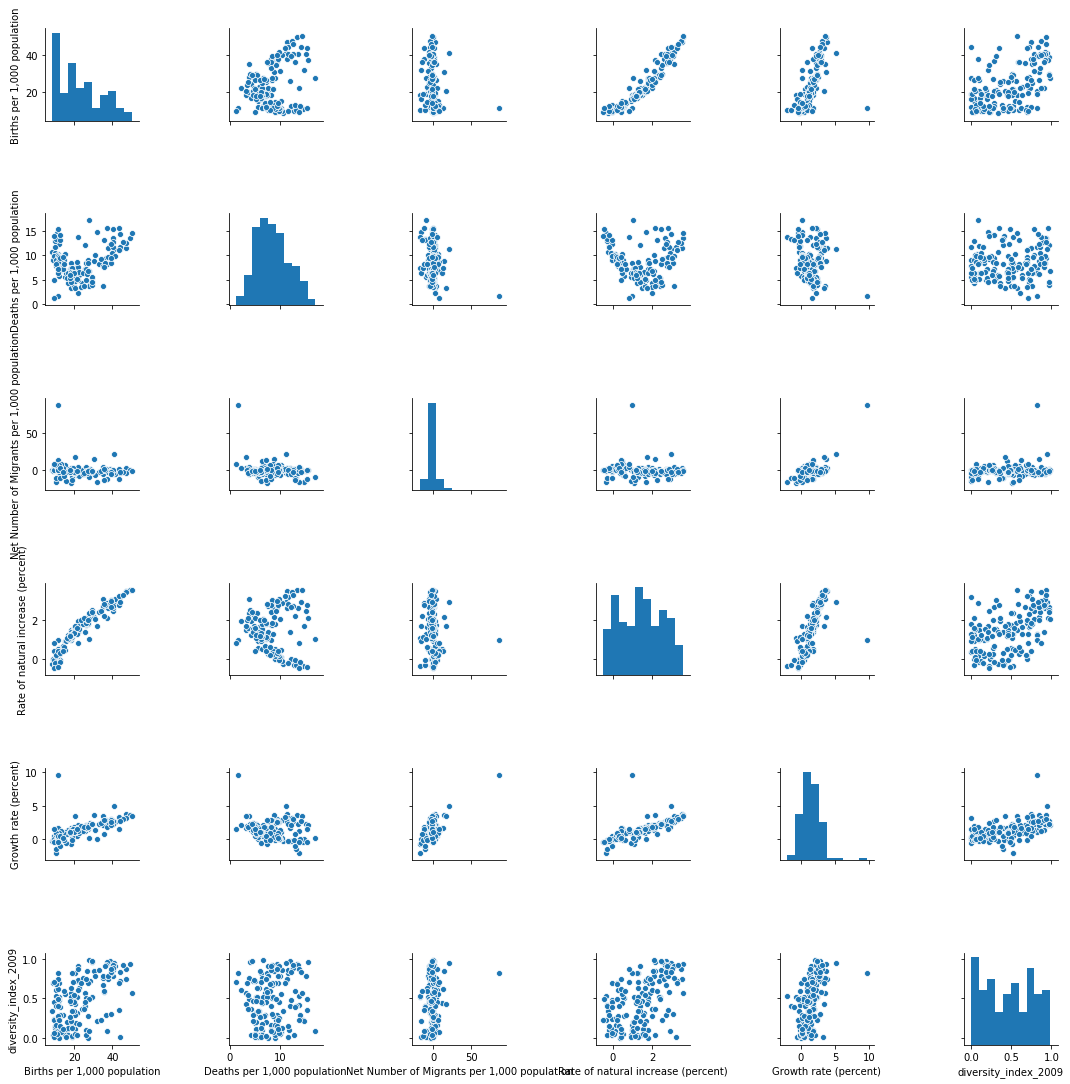

In [243]:
sns.pairplot(df[['Births per 1,000 population',
                 'Deaths per 1,000 population',
                 'Net Number of Migrants per 1,000 population',
                 'Rate of natural increase (percent)',
                 'Growth rate (percent)',
                 'diversity_index_2009']]);

In [185]:
df[df['Net Number of Migrants per 1,000 population'] >50]

,Region,country,Year,"Births per 1,000 population","Deaths per 1,000 population","Net Number of Migrants per 1,000 population",Rate of natural increase (percent),Growth rate (percent),Population,Births,Deaths,Net Number of Migrants,Natural Increase,Population Change,continent,iso_a3,geometry,diversity_index_2009
116,World,Qatar,2009.0,11.4,1.6,86.4,0.98,9.61,1568525.0,17834,2494,135442,15340,150782,Asia,QAT,"POLYGON ((50.81010827006958 24.75474253997138,...",0.825


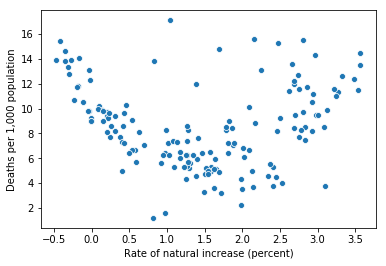

In [186]:
sns.scatterplot(df['Rate of natural increase (percent)'],df['Deaths per 1,000 population'])

In [187]:
df_geo = gpd.GeoDataFrame(df.drop(columns='geometry'), geometry=df['geometry'])

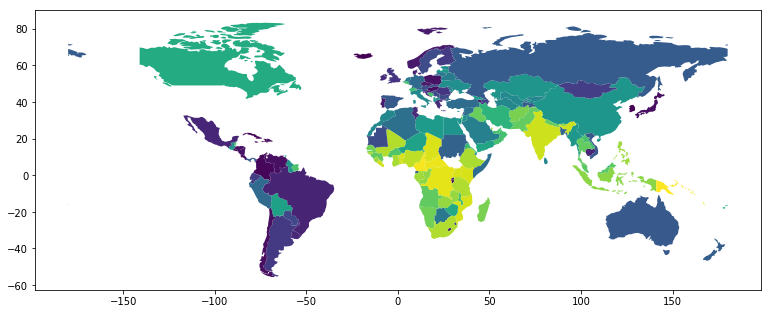

In [188]:
df_geo.plot(column='diversity_index_2009', figsize=(13,10))

In [144]:
world09.iloc[30:70,:]

,Region,country,Year,"Births per 1,000 population","Deaths per 1,000 population","Net Number of Migrants per 1,000 population",Rate of natural increase (percent),Growth rate (percent),Population,Births,Deaths,Net Number of Migrants,Natural Increase,Population Change
30,World,BurkinaFaso,2009,43.9,11.3,-3.7,3.27,2.9,15185326,667091,171139,-55882,495953,440071
31,World,Burma,2009,21.2,8.3,-7.2,1.28,0.57,51017774,1080046,425488,-366308,654558,288250
32,World,Burundi,2009,43.8,11.6,0,3.22,3.23,8831095,387067,102352,0,284715,284715
33,World,CaboVerde,2009,22.2,6.5,-0.7,1.57,1.5,501182,11131,3248,-341,7884,7543
34,World,Cambodia,2009,26.2,8.3,-0.4,1.78,1.75,14206230,371493,118054,-4972,253439,248467
35,World,Cameroon,2009,38.9,12,0.9,2.69,2.77,20262861,787820,243762,17831,544058,561889
36,World,Canada,2009,10.3,7.7,5.6,0.25,0.82,33487208,344248,259191,188533,85058,273590
37,World,CaymanIslands,2009,12.4,4.9,16.5,0.75,2.39,49035,606,240,808,366,1174
38,World,CentralAfricanRepublic,2009,37.1,15.6,0,2.15,2.15,4741916,175925,73974,0,101951,101951
39,World,Chad,2009,49.2,13.5,0.6,3.57,3.63,11562994,568784,155754,6822,413030,419852


In [146]:
world_geo[world_geo['country'] == 'France']

,pop_est,continent,country,iso_a3,gdp_md_est,geometry
55,64057792.0,Europe,France,FRA,2128000.0,(POLYGON ((-52.55642473001839 2.50470530843705...


In [153]:
diversity_index[diversity_index['iso_a3'] == 'FRA']

,diversity_index_2009,iso_a3


In [218]:
df.head()

,Region,country,Year,"Births per 1,000 population","Deaths per 1,000 population","Net Number of Migrants per 1,000 population",Rate of natural increase (percent),Growth rate (percent),Population,Births,Deaths,Net Number of Migrants,Natural Increase,Population Change,continent,iso_a3,geometry,diversity_index_2009
0,World,Afghanistan,2009.0,40.1,15.3,-1.9,2.47,2.28,28483631.0,1140769,436939,-54119,703831,649712,Asia,AFG,"POLYGON ((61.21081709172574 35.65007233330923,...",0.790
1,World,Albania,2009.0,11.6,5.7,-5.5,0.59,0.05,2982540.0,34597,16911,-16344,17686,1342,Europe,ALB,"POLYGON ((20.59024743010491 41.85540416113361,...",0.503
2,World,Algeria,2009.0,24.1,4.3,-1,1.98,1.88,35268128.0,848904,151653,-33857,697251,663393,Africa,DZA,"POLYGON ((11.99950564947161 23.47166840259645,...",0.360
3,World,Angola,2009.0,47,11.5,2.8,3.54,3.82,21803771.0,1023905,251179,60178,772726,832904,Africa,AGO,(POLYGON ((16.32652835456705 -5.87747039146621...,0.748
4,World,Argentina,2009.0,18.2,8.3,-0.2,0.99,0.97,40943942.0,745180,339835,-9827,405345,395518,South America,ARG,(POLYGON ((-65.50000000000003 -55.199999999999...,0.165


In [219]:
X = df.drop(columns=['Region','country','Year','continent',
                    'iso_a3','geometry',
                    'diversity_index_2009'])
                     
y = df['diversity_index_2009'].values

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)

In [221]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [235]:
model = Sequential()

model.add(Dense(32,
                activation='relu',
               )
         )

model.add(Dense(8,
                activation='relu',
               )
         )

model.add(Dense(8,
                activation='relu',
               )
         )

model.add(Dense(1
               )
         )

In [236]:
model.compile(loss='mse',
              optimizer=Adam(lr=.0005)
             )

In [237]:
model.fit(X_train_sc,
          y_train,
          epochs=100,
          validation_data=(X_test_sc, y_test)
         )

Train on 117 samples, validate on 39 samples
Epoch 1/100
117/117 [==============================] - 1s 4ms/step - loss: 0.2232 - val_loss: 0.2359
Epoch 2/100
117/117 [==============================] - 0s 76us/step - loss: 0.2104 - val_loss: 0.2183
Epoch 3/100
117/117 [==============================] - 0s 79us/step - loss: 0.1940 - val_loss: 0.2018
Epoch 4/100
117/117 [==============================] - 0s 101us/step - loss: 0.1825 - val_loss: 0.1855
Epoch 5/100
117/117 [==============================] - 0s 99us/step - loss: 0.1675 - val_loss: 0.1709
Epoch 6/100
117/117 [==============================] - 0s 92us/step - loss: 0.1561 - val_loss: 0.1583
Epoch 7/100
117/117 [==============================] - 0s 89us/step - loss: 0.1448 - val_loss: 0.1482
Epoch 8/100
117/117 [==============================] - 0s 88us/step - loss: 0.1340 - val_loss: 0.1400
Epoch 9/100
117/117 [==============================] - 0s 104us/step - loss: 0.1249 - val_loss: 0.1322
Epoch 10/100
117/117 [==============

Epoch 80/100
117/117 [==============================] - 0s 118us/step - loss: 0.0503 - val_loss: 0.1233
Epoch 81/100
117/117 [==============================] - 0s 124us/step - loss: 0.0501 - val_loss: 0.1215
Epoch 82/100
117/117 [==============================] - 0s 130us/step - loss: 0.0500 - val_loss: 0.1202
Epoch 83/100
117/117 [==============================] - 0s 117us/step - loss: 0.0498 - val_loss: 0.1188
Epoch 84/100
117/117 [==============================] - 0s 116us/step - loss: 0.0497 - val_loss: 0.1191
Epoch 85/100
117/117 [==============================] - 0s 81us/step - loss: 0.0496 - val_loss: 0.1199
Epoch 86/100
117/117 [==============================] - 0s 104us/step - loss: 0.0494 - val_loss: 0.1212
Epoch 87/100
117/117 [==============================] - 0s 114us/step - loss: 0.0494 - val_loss: 0.1228
Epoch 88/100
117/117 [==============================] - 0s 104us/step - loss: 0.0492 - val_loss: 0.1232
Epoch 89/100
117/117 [==============================] - 0s 89us/s

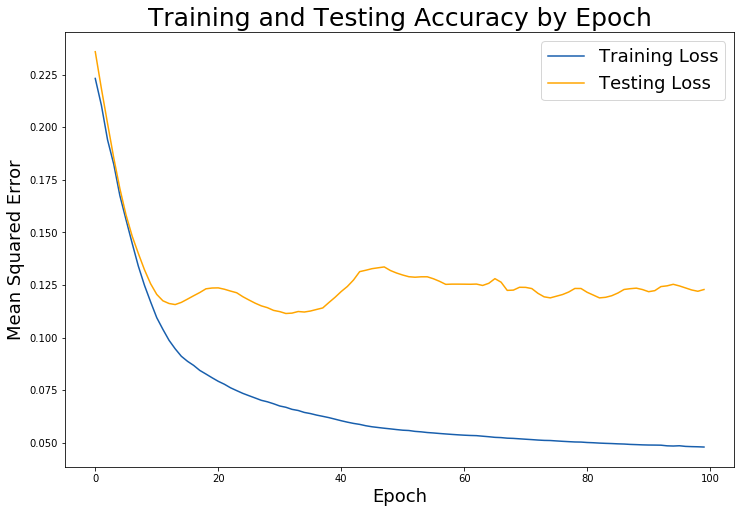

In [239]:
# Check out our train loss and test loss over epochs.
train_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Mean Squared Error', fontsize = 18)

plt.legend(fontsize = 18);

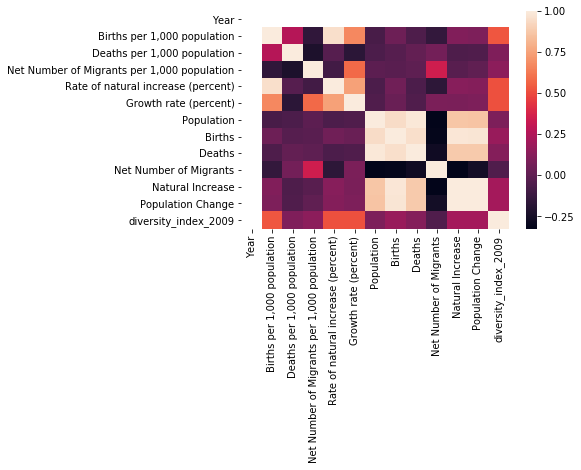

In [244]:
sns.heatmap(df.corr())